<a href="https://colab.research.google.com/github/Amal-Alalami/FinalProject/blob/main/CNN_ABF%26CLAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# to generate data
from keras.preprocessing.image import ImageDataGenerator

# to build model
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
%matplotlib inline

# Upload Dataset

In [46]:
!7z x archive.zip



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 35779075 bytes (35 MiB)

Extracting archive: archive.zip
 64% 4096 Open              --
Path = archive.zip
Type = zip
Physical Size = 35779075

  0%     10% 711         21% 1472 - Alzheimer_s Dataset/train/MildDemented/mildDem272.jpg                                                                  32% 2137          42% 2747 - Alzheimer_s Dataset/train/NonDemented/nonDem1627.jpg                                                                

# **Pre-processed data and Visualize Sample Images**

In [40]:
# Method to print sample images from each class

def print_sample_images(train_path, class_labels):

  plt.figure(figsize=(10, 10))
  for i, class_name in enumerate(class_labels):

    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_path, class_name)))
    img_path = os.path.join(train_path, class_name, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

  plt.show()

**Sample of train images before pre-processing data from each class**

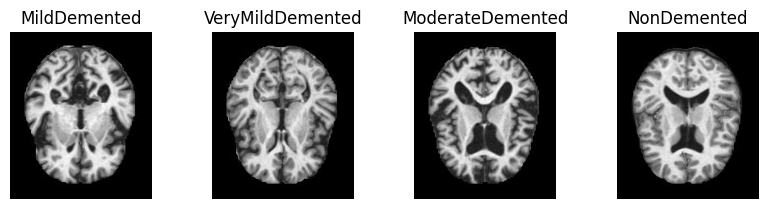

In [48]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

**Pre-processing data**

In [42]:
def process_images_in_folder(folder_path):
  width, height = 128, 128

  for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path)

    #pre-processing data using Adaptive Bilateral Filter(ABF) & Contrast Limited Adaptive Histogram Equalization (CLAHE)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bilateral = cv2.bilateralFilter(gray_image, 5, 0.3, 0.3)
    clahe = cv2.createCLAHE(clipLimit=1)
    preprocessed_image = clahe.apply(bilateral)

    # Save the pre-processed image with the same filename
    cv2.imwrite(image_path, preprocessed_image)

In [49]:
train_data_path = '/content/Alzheimer_s Dataset/train'
test_data_path = '/content/Alzheimer_s Dataset/test'
class_labels = os.listdir('/content/Alzheimer_s Dataset/train')


def data_to_be_processed(class_path ,class_labels):
  for class_label in class_labels:
    class_folder_path = os.path.join(class_path, class_label)
    process_images_in_folder(class_folder_path)



# train data
data_to_be_processed(train_data_path, class_labels)

# test data
data_to_be_processed(test_data_path, class_labels)

**Sample of train images after pre-processing data from each class**

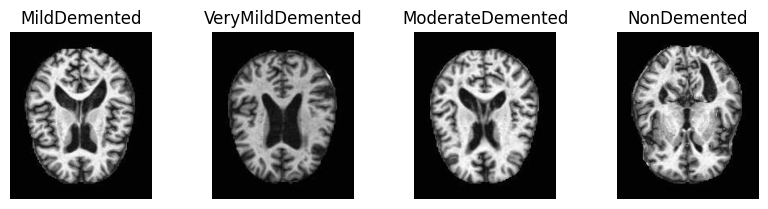

In [51]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

# Images in train data

In [52]:
train_folder = '/content/Alzheimer_s Dataset/train'
class_names_train_folder = os.listdir(train_folder)
class_count = []

for class_name in class_names_train_folder:
  num_images = len(os.listdir(os.path.join(train_folder, class_name)))
  class_count.append(num_images)
  print(f"Class {class_name}: {num_images} images")


Class MildDemented: 717 images
Class VeryMildDemented: 1792 images
Class ModerateDemented: 52 images
Class NonDemented: 2560 images


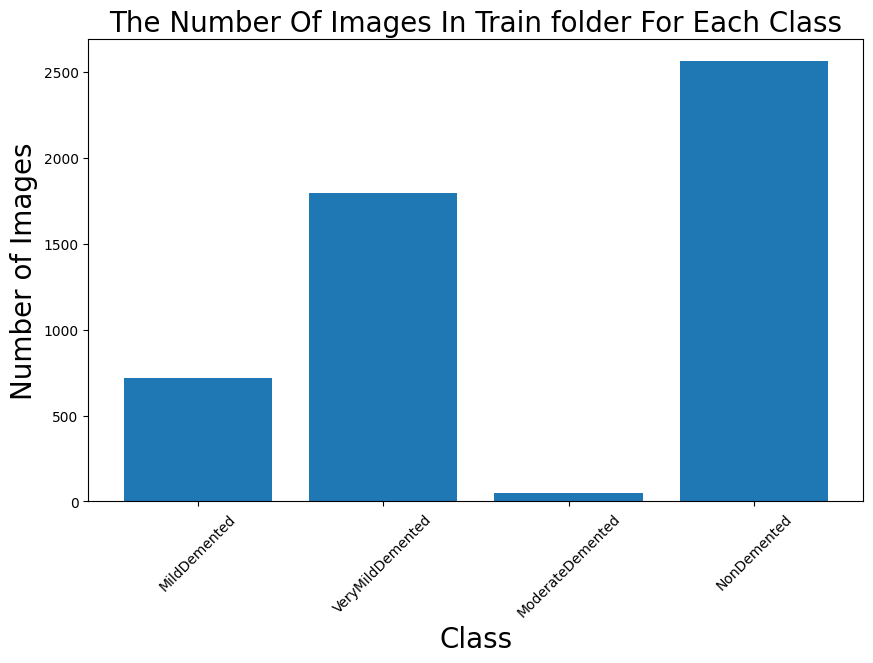

In [53]:

plt.figure(figsize=(10, 6))
plt.bar(class_names_train_folder, class_count)

plt.title('The Number Of Images In Train folder For Each Class', fontsize=20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Images", fontsize=20)
plt.xticks(rotation=45)

plt.show()


# **Train Test split and Build Model**

In [54]:
#  Loads all images and labels from a directory and converts them to a NumPy array.

def load_train_data(data_dir):

  image_width, image_height = 128, 128
  class_names = os.listdir(data_dir)
  class_name_to_label = {class_name: i for i, class_name in enumerate(class_names)}
  images = []
  labels = []

  for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):

      image_path = os.path.join(class_path, filename)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      image = cv2.resize(image, (image_width, image_height))
      image = image / 255.0 #normalize

      label = class_name_to_label[class_name]
      images.append(image)
      labels.append(label)

  # Convert the list of images to a NumPy array
  X_train = np.asarray(images)
  Y_train = np.asarray(labels)

  return X_train, Y_train

In [55]:
X_train , Y_train = load_train_data('/content/Alzheimer_s Dataset/train')

In [56]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: (5121, 128, 128)
Y_train shape: (5121,)


In [57]:
Y_train

array([0, 0, 0, ..., 3, 3, 3])

In [58]:
Y_train = tf.keras.utils.to_categorical(Y_train)

In [59]:
Y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [60]:
print(Y_train.shape)

(5121, 4)


In [61]:
X_test , Y_test = load_train_data('/content/Alzheimer_s Dataset/test')

In [62]:
print(f"X_test original shape: {X_test.shape}")
print(f"Y_test original shape: {Y_test.shape}")

X_test original shape: (1279, 128, 128)
Y_test original shape: (1279,)


In [63]:
X_val, X_test, Y_val , Y_test = train_test_split(X_test, Y_test, test_size=0.7, random_state=42)

In [64]:
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_test shape: (896, 128, 128)
Y_test shape: (896,)


In [65]:
print(f"X_validation shape: {X_val.shape}")
print(f"Y_validation shape: {Y_val.shape}")

X_validation shape: (383, 128, 128)
Y_validation shape: (383,)


In [66]:
Y_val

array([1, 3, 3, 0, 3, 3, 3, 0, 2, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 0,
       0, 1, 1, 0, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 0, 0, 3, 1, 3, 3,
       0, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 1, 1, 3, 1, 0, 3, 0, 3, 3, 1, 3,
       3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 1, 0, 2, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 1, 3, 3, 3, 3, 3,
       1, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 0, 1, 0, 0, 1,
       3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0, 1, 3, 0, 0, 1, 1, 3, 0, 3,
       3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1,
       3, 3, 3, 1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 3, 1, 0, 1, 3, 1, 3, 3, 1,
       3, 1, 3, 0, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3,
       1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 0, 3,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 0, 3, 3,

In [67]:
Y_val_cat = tf.keras.utils.to_categorical(Y_val)

In [68]:
Y_val_cat

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [69]:
print(Y_val_cat.shape)

(383, 4)


In [70]:
Y_test

array([3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 3, 1, 1, 3, 3,
       1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 0, 1, 3, 3, 1, 1, 3, 0,
       1, 3, 1, 0, 3, 3, 3, 3, 0, 0, 0, 1, 0, 3, 3, 3, 1, 1, 3, 3, 1, 3,
       3, 1, 3, 3, 3, 1, 3, 0, 0, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1,
       3, 1, 0, 1, 3, 3, 3, 0, 1, 0, 1, 3, 1, 1, 2, 3, 0, 3, 1, 1, 0, 3,
       1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 1,
       3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 1, 1, 1, 1, 1, 3, 3, 1, 0, 0, 3, 1,
       3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 1, 3, 3, 3,
       2, 0, 1, 1, 1, 1, 0, 3, 3, 1, 0, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 1,
       3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 1, 1, 1, 1,
       3, 1, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 3, 3, 3, 1, 1,
       0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 0, 3, 3, 3,
       1, 1, 3, 3, 0, 1, 3, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3,
       3, 1, 1, 3, 0, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3,

In [71]:
Y_test_cat = tf.keras.utils.to_categorical(Y_test)

In [72]:
print(Y_test_cat.shape)

(896, 4)


In [73]:
Y_test_cat

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [74]:
# CNN model
model1 = Sequential()
inputSize = (128,128,1)

#ilters=32, kernel_size=(4,4), input_shape=(28,28,1), activation='relu')
model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(4, activation = 'softmax'))
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [75]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)       

In [76]:
results = model1.fit(X_train, Y_train, epochs=35, validation_data=(X_val, Y_val_cat))

Epoch 1/35
161/161 [==============================] - 106s 644ms/step - loss: 0.9580 - accuracy: 0.5401 - val_loss: 1.1280 - val_accuracy: 0.4935
Epoch 2/35
161/161 [==============================] - 96s 599ms/step - loss: 0.7679 - accuracy: 0.6434 - val_loss: 0.9314 - val_accuracy: 0.5718
Epoch 3/35
161/161 [==============================] - 94s 587ms/step - loss: 0.4855 - accuracy: 0.7920 - val_loss: 0.8609 - val_accuracy: 0.6475
Epoch 4/35
161/161 [==============================] - 95s 591ms/step - loss: 0.2355 - accuracy: 0.9108 - val_loss: 3.0527 - val_accuracy: 0.4021
Epoch 5/35
161/161 [==============================] - 98s 606ms/step - loss: 0.1215 - accuracy: 0.9584 - val_loss: 2.4253 - val_accuracy: 0.4935
Epoch 6/35
161/161 [==============================] - 96s 594ms/step - loss: 0.0620 - accuracy: 0.9793 - val_loss: 1.9899 - val_accuracy: 0.5718
Epoch 7/35
161/161 [==============================] - 97s 606ms/step - loss: 0.0376 - accuracy: 0.9873 - val_loss: 2.0722 - val_a

In [77]:
print(model1.output_shape)

(None, 4)


In [78]:
hist_=pd.DataFrame(results.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.957962,0.540129,1.127994,0.493473
1,0.767898,0.643429,0.931398,0.571802
2,0.485498,0.792033,0.860868,0.647520
3,0.235526,0.910760,3.052733,0.402089
4,0.121469,0.958407,2.425333,0.493473
5,0.061995,0.979301,1.989923,0.571802
6,0.037555,0.987307,2.072236,0.631854
7,0.025630,0.991994,3.795284,0.488251
8,0.035493,0.985745,2.000748,0.608355
9,0.020106,0.993556,4.532925,0.488251


# **Model Evaluation**

In [79]:
loss, acc = model1.evaluate(X_test, Y_test_cat)
print('loss: ', loss)
print('accuracy ', acc)

28/28 [==============================] - 5s 189ms/step - loss: 3.7344 - accuracy: 0.6127
loss:  3.7343995571136475
accuracy  0.6127232313156128


In [80]:
# Reshape Y_test to a 1-dimensional array
Y_test = Y_test.reshape(-1,)

predictions = model1.predict(X_test)
Y_predected = np.argmax(predictions, axis=1)
#Y_test_ = np.argmax(Y_test,axis=0)

df = pd.DataFrame({'Actual': Y_test, 'Prediction': Y_predected})
df

28/28 [==============================] - 4s 142ms/step


,Actual,Prediction
0,3,3
1,3,1
2,1,1
3,3,3
4,3,3
...,...,...
891,0,0
892,1,1
893,3,3
894,3,1


array([[ 36,  72,   0,  19],
       [ 13, 281,   0,  36],
       [  1,   3,   4,   0],
       [  7, 196,   0, 228]])

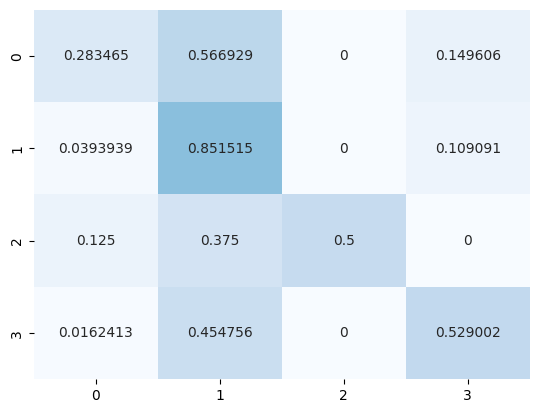

In [81]:
CM = confusion_matrix(Y_test,Y_predected)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [82]:
print(classification_report(Y_test, Y_predected))

              precision    recall  f1-score   support

           0       0.63      0.28      0.39       127
           1       0.51      0.85      0.64       330
           2       1.00      0.50      0.67         8
           3       0.81      0.53      0.64       431

    accuracy                           0.61       896
   macro avg       0.74      0.54      0.58       896
weighted avg       0.67      0.61      0.60       896

